### Analysis and plots for repeatability data


In [1]:
#Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import matplotlib.colors as clr
import matplotlib as mpl

#function that defines colors
def rgb(red, green, blue, maxColorValue):
    return (red/maxColorValue, green/maxColorValue, blue/maxColorValue)

#colors for barplots
col_1 = rgb(red=254, green=154, blue=1, maxColorValue=255) #yellow
col_2 = rgb(red=0, green=128, blue=128, maxColorValue=255) #green
col_3 = rgb(red=128, green=0, blue=128, maxColorValue=255) #purple
col_4 = rgb(red=138, green=54, blue=15, maxColorValue=255) #brown

#colors for heatmap
col_6 = rgb(red=254, green=254, blue=98, maxColorValue=255) #pale yellow
col_7 = rgb(red=211, green=95, blue=183, maxColorValue=255) #pink

#changing default font for matplotlib
mpl.rcParams['font.family'] = 'Roboto'

#output directory to save figures
odir= '/nfs/rnas/PRECISION/figures'

### Final numbers for repeatibility (mean for all features)

In [3]:
# Import dataframe containing repeatability data for all settings, all cohorts and all lesion locations
df=pd.read_csv('/nfs/rnas/PRECISION/paper/df_repeat.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df = df.loc[df["feature"] != "firstorder_TotalEnergy"] #exclude, same as Energy
# df=df.loc[df["lesion_location"]=='lung'] #LESION LOCATION FILTER
# df=df.loc[df["final_primary_tumor"]=='mixed'] #PRIMARY TUMOR FILTER
settings=['R1B12', 'R1B25', 'R3B12', 'R3B25']

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot=pd.DataFrame()
for s in settings:
    df_s=[]
    new_df=df[df['setting']==s]
    metric='ICC_LCL' #We use the lower bound of the 95%CI
    medians = new_df.groupby(['feature'])[metric].median() #We compute the median of every feature for all lesions, all cohorts
    medians= medians.sort_values(ascending=False)
    df_medians=medians.to_frame() #series to dataframe
    median_allfeat=np.round(np.percentile(df_medians['ICC_LCL'],50),3)
    q1_allfeat=np.round(np.percentile(df_medians['ICC_LCL'],25),3)
    q3_allfeat=np.round(np.percentile(df_medians['ICC_LCL'],75),3)
    df_s.append({
        'setting':s,
        'median_allfeat': median_allfeat, 
        'q1_allfeat': q1_allfeat,
        'q3_allfeat': q3_allfeat})
    df_s=pd.DataFrame(df_s)
    df_tot = pd.concat([df_tot, df_s], axis=0) 
df_tot

/config/.conda/envs/REPRO/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,setting,median_allfeat,q1_allfeat,q3_allfeat
0,R1B12,0.191,0.116,0.382
0,R1B25,0.199,0.103,0.344
0,R3B12,0.442,0.312,0.516
0,R3B25,0.415,0.306,0.516


### Repeatability distribution per setting

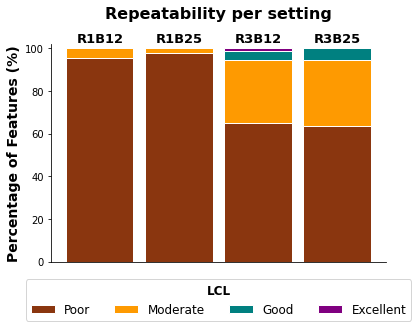

In [32]:
# Import dataframe containing repeatability data for all settings, all cohorts and all lesion locations
df=pd.read_csv('/nfs/rnas/PRECISION/paper/df_repeat.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]
# df=df.loc[df["lesion_location"]=='lung'] #LESION LOCATION FILTER
# df=df.loc[df["final_primary_tumor"]=='mixed'] #PRIMARY TUMOR FILTER
settings=['R1B12', 'R1B25', 'R3B12', 'R3B25']
groups=['poor', 'moderate', 'good', 'excellent']

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot=pd.DataFrame()
for s in settings:
    df_s=[]
    df_cols=['setting', 'poor', 'moderate', 'good', 'excellent']

    if s=='all':
        new_df=df
    else:
        new_df=df[df['setting']==s]
  
    metric='ICC_LCL' #We use the lower bound of the 95%CI
    medians = new_df.groupby(['feature'])[metric].median() #We compute the median of every feature for all lesions, all cohorts
    medians= medians.sort_values(ascending=False)
    df_medians=medians.to_frame() #series to dataframe

    # Now we create a column "poor, moderate, good, excellent" according to the ICC_LCL median:
    values=['excellent','good', 'moderate', 'poor']
    conditions=[(df_medians['ICC_LCL']>=0.9),(df_medians['ICC_LCL']>=0.75)&(df_medians['ICC_LCL']<0.9),(df_medians['ICC_LCL']>=0.5)&(df_medians['ICC_LCL']<0.75),(df_medians['ICC_LCL']<0.5)]
    df_medians['group']=np.select(conditions, values)

    # We count the percentage of each group 
    counts = df_medians['group'].value_counts().to_dict()
    total = sum(counts.values(), 0) #total number of features
    pctg_counts = {k: v / total for k, v in counts.items()}
    res = dict() #resulting dictionary
    for key in pctg_counts:
        res[key] = round((pctg_counts[key])*100,12)

    # Loop through group to obtain the setting df
    if "poor" in res: 
        val_poor=res["poor"]
    else:
        val_poor=0.0

    if "moderate" in res: 
        val_mod=res["moderate"]
    else:
        val_mod=0.0

    if "good" in res: 
        val_good=res["good"]
    else:
        val_good=0.0

    if "excellent" in res: 
        val_exc=res["excellent"]
    else:
        val_exc=0.0

    df_s.append({
        'setting':s,
        'poor':val_poor,
        'moderate':val_mod,
        'good':val_good,
        'excellent':val_exc})

    df_s=pd.DataFrame(df_s)
    df_tot = pd.concat([df_tot, df_s], axis=0) 

# plot
barWidth = 0.85
r = [0,1,2,3]
names = ('R1B12', 'R1B25', 'R3B12', 'R3B25')
# Create green Bars
plt.bar(r, df_tot["poor"], color=col_4, edgecolor='white', width=barWidth, label="Poor")
# Create orange Bars
plt.bar(r, df_tot["moderate"], bottom=df_tot["poor"], color=col_1, edgecolor='white', width=barWidth, label="Moderate")
# Create blue Bars
plt.bar(r,df_tot["good"], bottom=[i+j for i,j in zip(df_tot["poor"], df_tot["moderate"])], color=col_2, edgecolor='white', width=barWidth, label="Good")
 # Create blue Bars
plt.bar(r,df_tot["excellent"], bottom=[i+j+k for i,j,k in zip(df_tot["poor"], df_tot["moderate"], df_tot["good"])], color=col_3, edgecolor='white', width=barWidth, label="Excellent")


plt.xticks([], [])
plt.ylabel("Percentage of Features (%)", fontsize=14, weight='bold')
legend = plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4, fontsize=12, title="LCL", title_fontsize='large')
legend.get_title().set_fontweight('bold')
plt.ylim(0,102)
plt.title('Repeatability per setting', fontsize=16, weight='bold', y=1.09)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add subtitles
for i in range(len(r)):
    plt.text(x=r[i], y=103, s=names[i], ha='center', fontsize=13, weight='bold')

# Save figure
plt.savefig(odir+'/Figure_repeatpersetting.jpg',bbox_inches='tight', dpi=300)

### Repeatability distribution per feature class

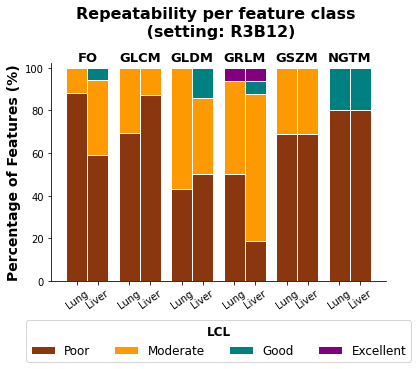

In [4]:
# Import dataframe containing repeatability data for all settings, all cohorts and all lesion locations
sett='R3B12'
df=pd.read_csv('/nfs/rnas/PRECISION/paper/df_repeat.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]
df=df.loc[df["setting"]==sett] #LESION LOCATION FILTER
groups=['poor', 'moderate', 'good', 'excellent']
feat_classes=['firstorder', 'glcm', 'gldm', 'glrlm', 'glszm', 'ngtdm']
df=df.loc[df["lesion_location"]=='liver'] #SETTING FILTER. I chose R3B12 because it is the setting with the highest number of repeatable features. 
df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot_liver=pd.DataFrame()
for s in feat_classes:
    df_s=[]

    if s=='all':
        new_df=df
    else:
        new_df=df[df['feature_class']==s]
  
    metric='ICC_LCL' #We use the lower bound of the 95%CI
    medians = new_df.groupby(['feature'])[metric].median() #We compute the median of every feature for all lesions, all cohorts
    medians= medians.sort_values(ascending=False)
    df_medians=medians.to_frame() #series to dataframe
    # Now we create a column "poor, moderate, good, excellent" according to the ICC_LCL median:
    values=['excellent','good', 'moderate', 'poor']
    conditions=[(df_medians['ICC_LCL']>=0.9),(df_medians['ICC_LCL']>=0.75)&(df_medians['ICC_LCL']<0.9),(df_medians['ICC_LCL']>=0.5)&(df_medians['ICC_LCL']<0.75),(df_medians['ICC_LCL']<0.5)]
    df_medians['group']=np.select(conditions, values)

    # We count the percentage of each group 
    counts = df_medians['group'].value_counts().to_dict()
    total = sum(counts.values(), 0) #total number of features
    pctg_counts = {k: v / total for k, v in counts.items()}
    res = dict() #resulting dictionary
    for key in pctg_counts:
        res[key] = round((pctg_counts[key])*100,12)

    # Loop through group to obtain the setting df
    if "poor" in res: 
        val_poor=res["poor"]
    else:
        val_poor=0.0

    if "moderate" in res: 
        val_mod=res["moderate"]
    else:
        val_mod=0.0

    if "good" in res: 
        val_good=res["good"]
    else:
        val_good=0.0

    if "excellent" in res: 
        val_exc=res["excellent"]
    else:
        val_exc=0.0

    df_s.append({
        'feature_class':s,
        'poor':val_poor,
        'moderate':val_mod,
        'good':val_good,
        'excellent':val_exc})

    df_s=pd.DataFrame(df_s)
    df_tot_liver = pd.concat([df_tot_liver, df_s], axis=0) 


############################################## LUNG
# Import dataframe containing repeatability data for all settings, all cohorts and all lesion locations
df=pd.read_csv('/nfs/rnas/PRECISION/paper/df_repeat.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]
df=df.loc[df["setting"]==sett] #LESION LOCATION FILTER
groups=['poor', 'moderate', 'good', 'excellent']
feat_classes=['firstorder', 'glcm', 'gldm', 'glrlm', 'glszm', 'ngtdm']
df=df.loc[df["lesion_location"]=='lung'] #SETTING FILTER. I chose R3B12 because it is the setting with the highest number of repeatable features. 
df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot_lung=pd.DataFrame()
for s in feat_classes:
    df_s=[]

    if s=='all':
        new_df=df
    else:
        new_df=df[df['feature_class']==s]
  
    metric='ICC_LCL' #We use the lower bound of the 95%CI
    medians = new_df.groupby(['feature'])[metric].median() #We compute the median of every feature for all lesions, all cohorts
    medians= medians.sort_values(ascending=False)
    df_medians=medians.to_frame() #series to dataframe
    # Now we create a column "poor, moderate, good, excellent" according to the ICC_LCL median:
    values=['excellent','good', 'moderate', 'poor']
    conditions=[(df_medians['ICC_LCL']>=0.9),(df_medians['ICC_LCL']>=0.75)&(df_medians['ICC_LCL']<0.9),(df_medians['ICC_LCL']>=0.5)&(df_medians['ICC_LCL']<0.75),(df_medians['ICC_LCL']<0.5)]
    df_medians['group']=np.select(conditions, values)

    # We count the percentage of each group 
    counts = df_medians['group'].value_counts().to_dict()
    total = sum(counts.values(), 0) #total number of features
    pctg_counts = {k: v / total for k, v in counts.items()}
    res = dict() #resulting dictionary
    for key in pctg_counts:
        res[key] = round((pctg_counts[key])*100,12)

    # Loop through group to obtain the setting df
    if "poor" in res: 
        val_poor=res["poor"]
    else:
        val_poor=0.0

    if "moderate" in res: 
        val_mod=res["moderate"]
    else:
        val_mod=0.0

    if "good" in res: 
        val_good=res["good"]
    else:
        val_good=0.0

    if "excellent" in res: 
        val_exc=res["excellent"]
    else:
        val_exc=0.0

    df_s.append({
        'feature_class':s,
        'poor':val_poor,
        'moderate':val_mod,
        'good':val_good,
        'excellent':val_exc})

    df_s=pd.DataFrame(df_s)
    df_tot_lung= pd.concat([df_tot_lung, df_s], axis=0) 

df_tot_lung=df_tot_lung.set_index('feature_class')
df_tot_liver=df_tot_liver.set_index('feature_class')
df1=df_tot_liver
df2=df_tot_lung

# plot
barWidth = 0.4
names2 = ('FO', 'GLCM', 'GLDM', 'GRLM', 'GSZM', 'NGTM')
X_axis = np.arange(len(names2))

# Create green Bars
plt.bar(X_axis + 0.2, df1["poor"], color=col_4, edgecolor='white', width=barWidth, label="Poor")
plt.bar(X_axis - 0.2, df2["poor"], color=col_4, edgecolor='white', width=barWidth, label="Poor")

# Create orange Bars
plt.bar(X_axis + 0.2, df1["moderate"], bottom=df1["poor"], color=col_1, edgecolor='white', width=barWidth, label="Moderate")
plt.bar(X_axis - 0.2, df2["moderate"], bottom=df2["poor"], color=col_1, edgecolor='white', width=barWidth, label="Moderate")

# Create blue Bars
plt.bar(X_axis + 0.2,df1["good"], bottom=[i+j for i,j in zip(df1["poor"], df1["moderate"])], color=col_2, edgecolor='white', width=barWidth, label="Good")
plt.bar(X_axis - 0.2,df2["good"], bottom=[i+j for i,j in zip(df2["poor"], df2["moderate"])], color=col_2, edgecolor='white', width=barWidth, label="Good")

 # Create blue Bars
plt.bar(X_axis + 0.2,df1["excellent"], bottom=[i+j+k for i,j,k in zip(df1["poor"], df1["moderate"], df1["good"])], color=col_3, edgecolor='white', width=barWidth, label="Excellent")
plt.bar(X_axis - 0.2,df2["excellent"], bottom=[i+j+k for i,j,k in zip(df2["poor"], df2["moderate"], df2["good"])], color=col_3, edgecolor='white', width=barWidth, label="Excellent")

# Custom x axis
r=[-0.2, 0.2,  0.8, 1.2, 1.8, 2.2,  2.8, 3.2, 3.8, 4.2, 4.8, 5.2]
names = ('Lung', 'Liver', 'Lung', 'Liver', 'Lung', 'Liver', 'Lung', 'Liver', 'Lung', 'Liver', 'Lung', 'Liver')
plt.xticks(r, names, rotation=35)
plt.ylabel("Percentage of Features (%)", fontsize=14, weight='bold')
plt.ylim(0,102)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Repeatability per feature class \n (setting: '+sett+')',  weight='bold', y=1.1, fontsize=16)

# Add subtitles
r2=[0,1,2,3,4,5]
for i in range(len(names2)):
    plt.text(x=r2[i], y=103, s=names2[i], ha='center', fontsize=13, weight='bold')

# Adding Legend with bold title + not duplicated
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=4, fontsize=12, title="LCL", title_fontsize='large')
legend.get_title().set_fontweight('bold')

plt.savefig(odir+'/Figure2B_repeatpersetting_'+sett+'.jpg',bbox_inches='tight', dpi=300)

### Repeatability distribution per cohort

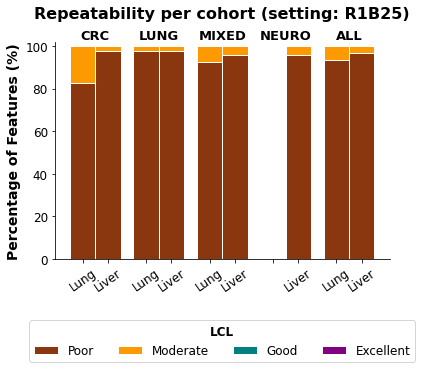

In [44]:
# Import dataframe containing repeatability data for all settings, all cohorts and all lesion locations
sett='R1B25'
df=pd.read_csv('/nfs/rnas/PRECISION/paper/df_repeat.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df=df.loc[df["setting"]==sett] #LESION LOCATION FILTER
df=df.loc[df["lesion_location"]=='liver'] #ensure only liver and lung lesions present
primary_tumors=['colorectal', 'lung', 'mixed', 'neuroendocrine', 'all']
lesion_location=['liver', 'lung']
groups=['poor', 'moderate', 'good', 'excellent']

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot_liver=pd.DataFrame()
for s in primary_tumors:
    df_s=[]
    if s=='all':
        new_df2=df
    else:
        new_df2=df[df['final_primary_tumor']==s]
    metric='ICC_LCL' #We use the lower bound of the 95%CI
    medians = new_df2.groupby(['feature'])[metric].median() #We compute the median for every feature
    medians= medians.sort_values(ascending=False)
    df_medians=medians.to_frame() #series to dataframe

    # Now we create a column "poor, moderate, good, excellent" according to the ICC_LCL median:
    values=['excellent','good', 'moderate', 'poor']
    conditions=[(df_medians['ICC_LCL']>=0.9),(df_medians['ICC_LCL']>=0.75)&(df_medians['ICC_LCL']<0.9),(df_medians['ICC_LCL']>=0.5)&(df_medians['ICC_LCL']<0.75),(df_medians['ICC_LCL']<0.5)]
    df_medians['group']=np.select(conditions, values)

    # We count the percentage of each group 
    counts = df_medians['group'].value_counts().to_dict()
    total = sum(counts.values(), 0) #total number of features
    pctg_counts = {k: v / total for k, v in counts.items()}
    res = dict() #resulting dictionary
    for key in pctg_counts:
        res[key] = round((pctg_counts[key])*100,12)

    # Loop through group to obtain the setting df
    if "poor" in res: 
        val_poor=res["poor"]
    else:
        val_poor=0.0

    if "moderate" in res: 
        val_mod=res["moderate"]
    else:
        val_mod=0.0

    if "good" in res: 
        val_good=res["good"]
    else:
        val_good=0.0

    if "excellent" in res: 
        val_exc=res["excellent"]
    else:
        val_exc=0.0

    df_s.append({
        'primary_tumor':s,
        'poor':val_poor,
        'moderate':val_mod,
        'good':val_good,
        'excellent':val_exc})
    df_s=pd.DataFrame(df_s)
    df_tot_liver = pd.concat([df_tot_liver, df_s], axis=0) 


#### LUNG DATAFRAME

# Import dataframe containing repeatability data for all settings, all cohorts and all lesion locations
df=pd.read_csv('/nfs/rnas/REPRO/paper/df_repeat.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df=df.loc[df["setting"]==sett] #LESION LOCATION FILTER
df=df.loc[df["lesion_location"]=='lung'] #ensure only liver and lung lesions present
primary_tumors=['colorectal', 'lung', 'mixed', 'neuroendocrine', 'all']
groups=['poor', 'moderate', 'good', 'excellent']

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot_lung=pd.DataFrame()
for s in primary_tumors:
    df_s=[]
    if s=='all':
        new_df2=df
    else:
        new_df2=df[df['final_primary_tumor']==s]
    metric='ICC_LCL' #We use the lower bound of the 95%CI
    medians = new_df2.groupby(['feature'])[metric].median() #We compute the median for every feature
    medians= medians.sort_values(ascending=False)
    df_medians=medians.to_frame() #series to dataframe

    # Now we create a column "poor, moderate, good, excellent" according to the ICC_LCL median:
    values=['excellent','good', 'moderate', 'poor']
    conditions=[(df_medians['ICC_LCL']>=0.9),(df_medians['ICC_LCL']>=0.75)&(df_medians['ICC_LCL']<0.9),(df_medians['ICC_LCL']>=0.5)&(df_medians['ICC_LCL']<0.75),(df_medians['ICC_LCL']<0.5)]
    df_medians['group']=np.select(conditions, values)

    # We count the percentage of each group 
    counts = df_medians['group'].value_counts().to_dict()
    total = sum(counts.values(), 0) #total number of features
    pctg_counts = {k: v / total for k, v in counts.items()}
    res = dict() #resulting dictionary
    for key in pctg_counts:
        res[key] = round((pctg_counts[key])*100,12)

    # Loop through group to obtain the setting df
    if "poor" in res: 
        val_poor=res["poor"]
    else:
        val_poor=0.0

    if "moderate" in res: 
        val_mod=res["moderate"]
    else:
        val_mod=0.0

    if "good" in res: 
        val_good=res["good"]
    else:
        val_good=0.0

    if "excellent" in res: 
        val_exc=res["excellent"]
    else:
        val_exc=0.0

    df_s.append({
        'primary_tumor':s,
        'poor':val_poor,
        'moderate':val_mod,
        'good':val_good,
        'excellent':val_exc})
    df_s=pd.DataFrame(df_s)
    df_tot_lung = pd.concat([df_tot_lung, df_s], axis=0) 

df_tot_lung=df_tot_lung.set_index('primary_tumor')
df_tot_liver=df_tot_liver.set_index('primary_tumor')

df1=df_tot_liver
df2=df_tot_lung

# plot
barWidth = 0.4
names2 = ('CRC', 'LUNG', 'MIXED', 'NEURO', 'ALL')
X_axis = np.arange(len(names2))

# Create green Bars
plt.bar(X_axis + 0.2, df1["poor"], color=col_4, edgecolor='white', width=barWidth, label="Poor")
plt.bar(X_axis - 0.2, df2["poor"], color=col_4, edgecolor='white', width=barWidth, label="Poor")

# Create orange Bars
plt.bar(X_axis + 0.2, df1["moderate"], bottom=df1["poor"], color=col_1, edgecolor='white', width=barWidth, label="Moderate")
plt.bar(X_axis - 0.2, df2["moderate"], bottom=df2["poor"], color=col_1, edgecolor='white', width=barWidth, label="Moderate")

# Create blue Bars
plt.bar(X_axis + 0.2,df1["good"], bottom=[i+j for i,j in zip(df1["poor"], df1["moderate"])], color=col_2, edgecolor='white', width=barWidth, label="Good")
plt.bar(X_axis - 0.2,df2["good"], bottom=[i+j for i,j in zip(df2["poor"], df2["moderate"])], color=col_2, edgecolor='white', width=barWidth, label="Good")

 # Create blue Bars
plt.bar(X_axis + 0.2,df1["excellent"], bottom=[i+j+k for i,j,k in zip(df1["poor"], df1["moderate"], df1["good"])], color=col_3, edgecolor='white', width=barWidth, label="Excellent")
plt.bar(X_axis - 0.2,df2["excellent"], bottom=[i+j+k for i,j,k in zip(df2["poor"], df2["moderate"], df2["good"])], color=col_3, edgecolor='white', width=barWidth, label="Excellent")

# Custom x axis
r=[-0.2, 0.2,  0.8, 1.2, 1.8, 2.2,  2.8, 3.2, 3.8, 4.2]
names = ('Lung', 'Liver', 'Lung', 'Liver', 'Lung', 'Liver', ' ', 'Liver', 'Lung', 'Liver')
plt.xticks(r, names, rotation=35, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Percentage of Features (%)", fontsize=14, weight='bold')
plt.ylim(0,102)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, title="LCL", fontsize=12, title_fontsize='large')
plt.title('Repeatability per cohort (setting: '+sett+')',  weight='bold', y=1.08, fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add subtitles
r2=[0,1,2,3,4]
for i in range(len(names2)):
    plt.text(x=r2[i], y=103, s=names2[i], ha='center', fontsize=13, weight='bold')

# Adding Legend with bold title + not duplicated
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=4, fontsize=12, title="LCL", title_fontsize='large')
legend.get_title().set_fontweight('bold')
plt.savefig(odir+'/FigureE3_repeatpercohort_'+sett+'.jpg',bbox_inches='tight', dpi=300)

### Heatmap Repeatability (Fiugre E5)

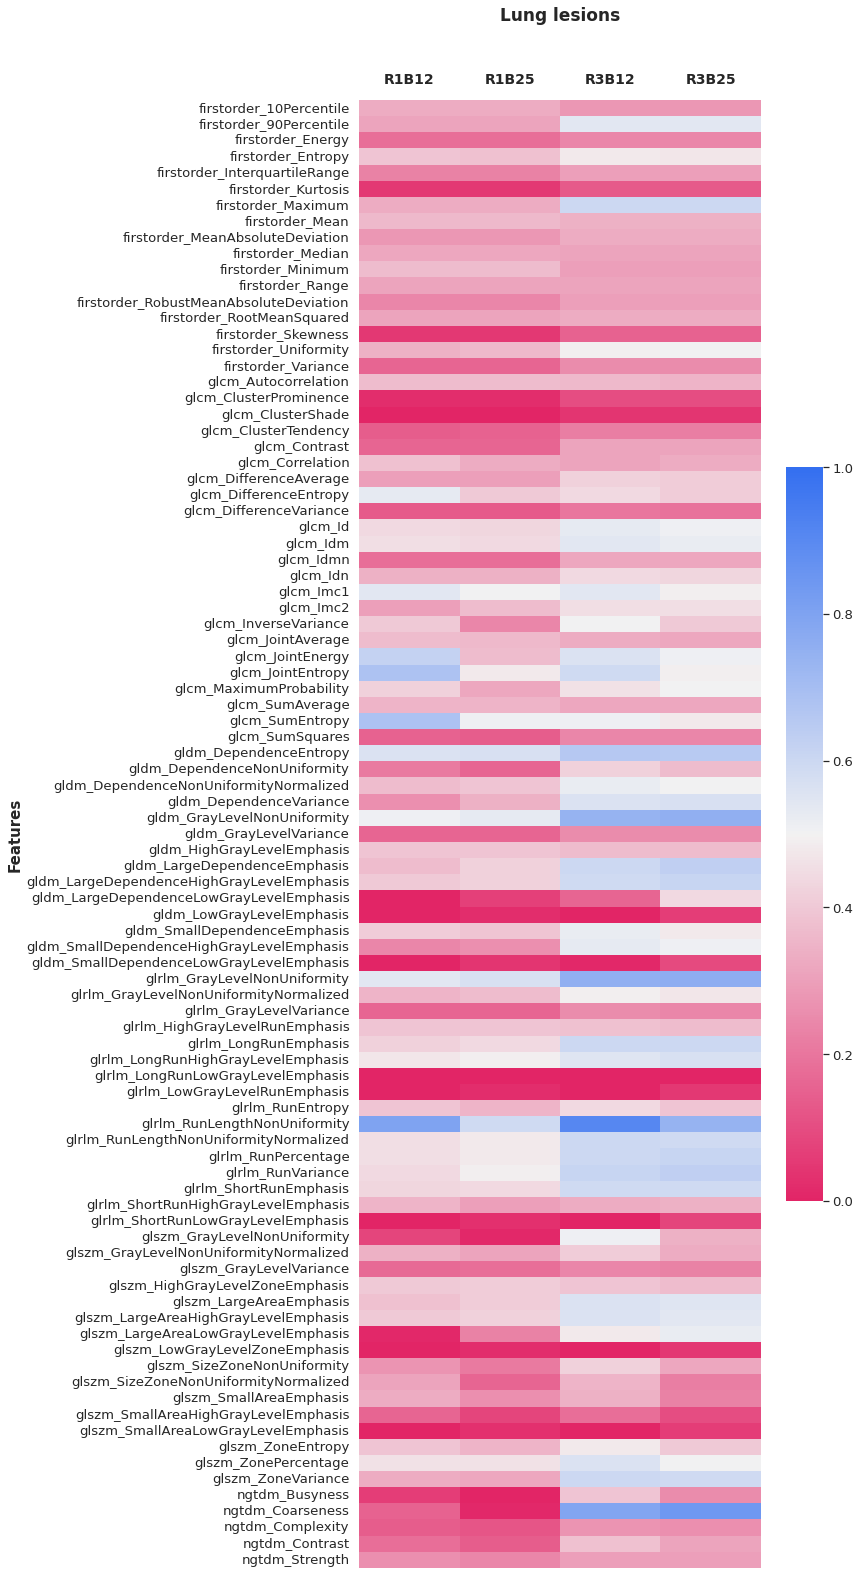

In [6]:
#input
experiment='lung'

#We create a df where rows are feaures and each column is one cohort
df=pd.read_csv('/nfs/rnas/PRECISION/paper/df_repeat.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df = df.loc[df["feature"] != "firstorder_TotalEnergy"] #remove total energy because its the same as energy
df=df.loc[df["lesion_location"]==experiment] #SETTING FILTER. I chose R3B12 because it is the setting with the highest number of repeatable features. 
groups=['poor', 'moderate', 'good', 'excellent']
settings=['R1B12', 'R1B25', 'R3B12', 'R3B25']

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot=pd.DataFrame()
for s in settings:
    if s=='allsettings':
        new_df=df
    else:
        new_df=df[df['setting']==s]

    LICC_metric='ICC_LCL' #We use the lower bound of the 95%CI
    LICC_medians = new_df.groupby(['feature'])[LICC_metric].median() #We compute the median for every feature
    df_LICC_medians=LICC_medians.to_frame().reset_index()  #series to dataframe

    #concatenate all three dataframes:
    df_total=df_LICC_medians.round(2)
    df_final_total= df_total[['feature','ICC_LCL']]
    cohort_lesionlocation=s
    df_final_total["cohort_lesion"] =cohort_lesionlocation
    df_tot = pd.concat([df_tot, df_final_total], axis=0) 

df_tot= df_tot[df_tot["cohort_lesion"].str.contains("neuroendocrine_lung") == False]
df_tot= df_tot[df_tot["cohort_lesion"].str.contains("neuroendocrine_all") == False]

#from df_tot we create df_plot
# names=('Exp.1 (R1B12)', 'Exp.2 (R1B25)', 'Exp.3 (R3B12)', 'Exp.4 (R3B25)')
names=('R1B12', 'R1B25', 'R3B12', 'R3B25')

df_plot=pd.DataFrame()
for name in names:
    df = df_tot[df_tot['cohort_lesion'] == name]
    df = df.rename(columns={"ICC_LCL":name})
    df = df[['feature',name]]
    df = df.set_index('feature')
    df_plot = pd.concat([df_plot, df], axis=1) 
#We plot the heatmap
plt.figure(figsize=(9,27))
color=sns.diverging_palette(0, 259, s=90,n=256)
sns.set(font_scale=1.2) 
ax= sns.heatmap(df_plot, cmap=color, vmin=0, vmax=1, cbar_kws={"shrink": 0.5, "location": "right"})
# ax.figure.axes[-1].yaxis.label.set_size(20)
plt.title('Lung lesions', weight='bold', y=1.05, fontsize=17)
plt.xticks([], [])
plt.ylabel("Features", fontsize=15, weight='bold')

# Add subtitles
r2=[0.5,1.5,2.5, 3.5]
for i in range(len(names)):
    plt.text(x=r2[i], y=-1, s=names[i], ha='center', fontsize=14, weight='bold')
plt.savefig(odir+'/FigureE5_'+experiment+'.svg',bbox_inches='tight', dpi=300)

### Heatmap REPRO (Figure E8)

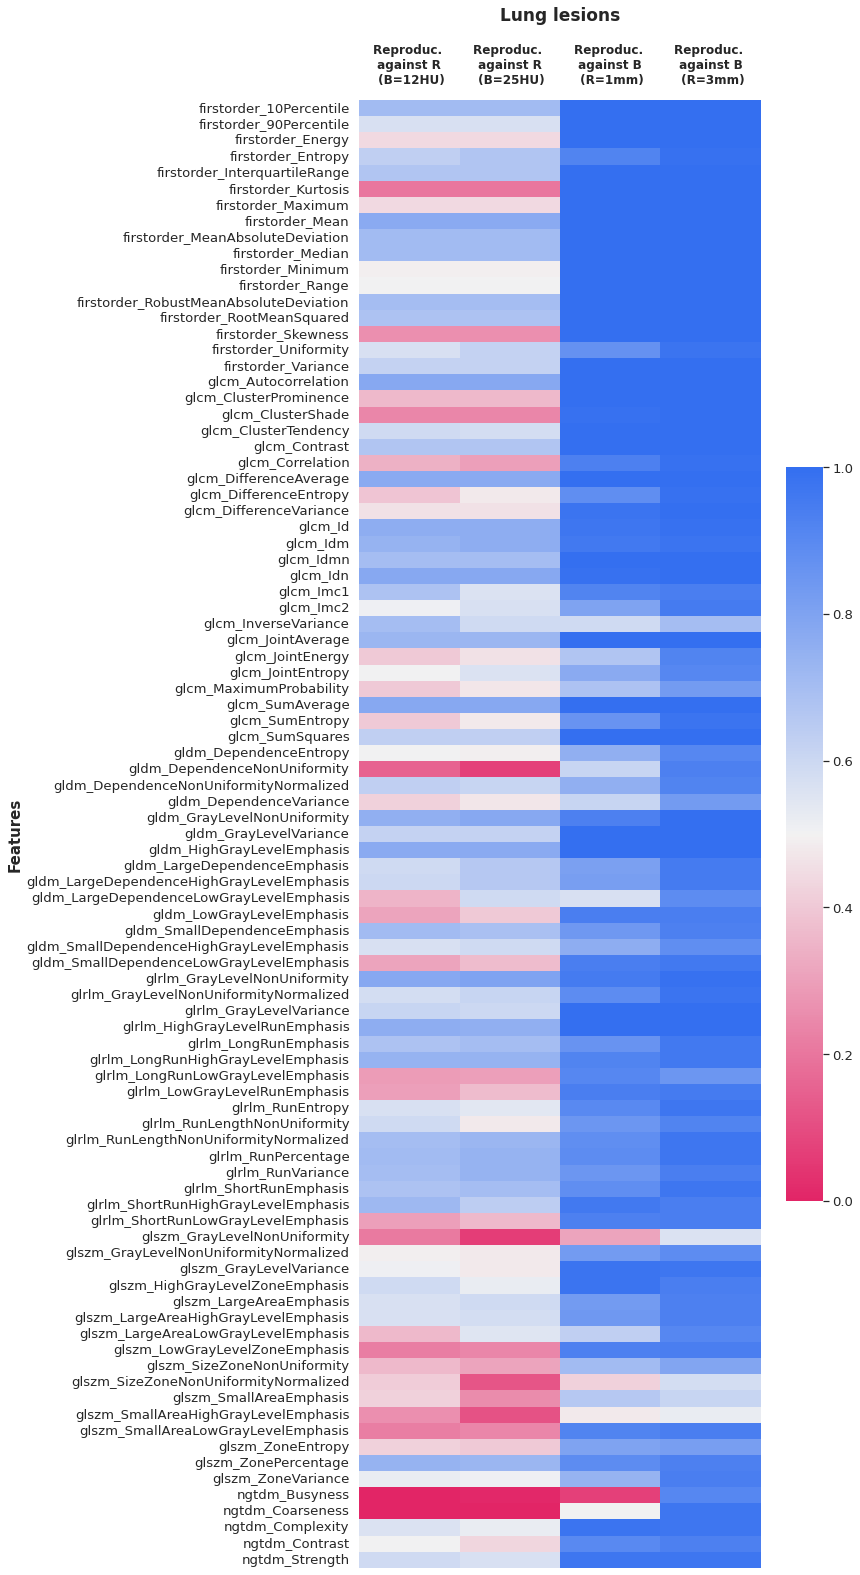

In [11]:
#input
experiment='lung'

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot=pd.DataFrame()

# we ad repro experiments columns
repro_experiments=['reproRB12', 'reproRB25', 'reproBR1', 'reproBR3']
df_tot2=pd.DataFrame()
for mydf in repro_experiments:
    #We create a df where rows are feaures and each column is one cohort
    df=pd.read_csv('/nfs/rnas/PRECISION/paper/df_'+mydf+'.csv') #read repeatability csv
    df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
    df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
    df = df.loc[df["feature"] != "firstorder_TotalEnergy"] #remove total energy because its the same as energy
    df=df.loc[df["lesion_location"]==experiment] #SETTING FILTER. I chose R3B12 because it is the setting with the highest number of repeatable features. 
    groups=['poor', 'moderate', 'good', 'excellent']

    LICC_metric='ICC_LCL' #We use the lower bound of the 95%CI
    LICC_medians = df.groupby(['feature'])[LICC_metric].median() #We compute the median for every feature
    df_LICC_medians=LICC_medians.to_frame().reset_index()  #series to dataframe

    #concatenate all three dataframes:
    df_total=df_LICC_medians.round(2)
    df_final_total= df_total[['feature','ICC_LCL']]
    df_final_total["cohort_lesion"] =mydf
    df_tot2 = pd.concat([df_tot2, df_final_total], axis=0) 

#we join repeat and repro 
final_df_tot=pd.concat([df_tot, df_tot2], axis=0) 

#from df_tot we create df_plot
names=('reproRB12', 'reproRB25', 'reproBR1', 'reproBR3')

df_plot=pd.DataFrame()
for name in names:
    df = final_df_tot[final_df_tot['cohort_lesion'] == name]
    df = df.rename(columns={"ICC_LCL":name})
    df = df[['feature',name]]
    df = df.set_index('feature')
    df_plot = pd.concat([df_plot, df], axis=1) 

# #We plot the heatmap
# plt.figure(figsize=(9,27))
# color=sns.cubehelix_palette(start=2, rot=-0.005, dark=0.05, light=.95, as_cmap=True)
# sns.heatmap(df_plot, cmap=color, vmin=0, vmax=1, cbar_kws={"shrink": 0.5, "location": "right"})
# plt.title('Heatmap of radiomics feature for all repro experiments: '+ experiment)
# plt.savefig(odir+'/figure6_heatmap_repro_'+experiment+'.svg',bbox_inches='tight', dpi=150)


#We plot the heatmap
plt.figure(figsize=(9,27))
color=sns.diverging_palette(0, 259, s=90,n=256)
sns.set(font_scale=1.2) 
ax= sns.heatmap(df_plot, cmap=color, vmin=0, vmax=1, cbar_kws={"shrink": 0.5, "location": "right"})
# ax.figure.axes[-1].yaxis.label.set_size(20)
plt.title('Lung lesions', weight='bold', y=1.05, fontsize=17)
plt.xticks([], [])
plt.ylabel("Features", fontsize=15, weight='bold')

# Add subtitles
r2=[0.5,1.5,2.5, 3.5]
names2=('Reproduc. \n against R \n (B=12HU)',
'Reproduc. \n against R \n (B=25HU)',
 'Reproduc. \n against B \n (R=1mm)',
 'Reproduc. \n against B \n (R=3mm)')

for i in range(len(names2)):
    plt.text(x=r2[i], y=-1, s=names2[i], ha='center', fontsize=12, weight='bold')
plt.savefig(odir+'/FigureE8_'+experiment+'.svg',bbox_inches='tight', dpi=300)